# Tema 11-Deteção de patologias de retinopatia diabética em imagens de retina

### Ainhoa Acinas 2024155121

### Introdução
Este projeto tem como objetivo desenvolver um sistema automatizado para classificar imagens da retina de acordo com o grau de retinopatia diabética (RD). 
Irá trabalhar com o conjunto de dados do Kaggle “Deteção de Retinopatia Diabética”: https://www.kaggle.com/c/diabetic-retinopathy-detection.

Como o conjunto total de dados tinha um tamanho de 88,29 GB, que é demasiado grande para este trabalho, decidi utilizar apenas as pastas “train.zip.005” e “test.zip.007”. Desta forma, só estaremos a trabalhar com 4,39 GB, o que irá acelerar bastante a velocidade de execução, mas mantendo bastantes imagens para podermos fazer um bom estudo mesmo assim.

In [2]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
from PIL import ImageStat
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from PIL import Image
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Configuración de visualización
sns.set_style("whitegrid")

## 1ª parte do Projeto


### Caracterização dos dados


Em primeiro lugar, analisamos as duas pastas de imagens correspondentes a treino e teste que temos e verificamos quantas imagens temos de cada uma, para termos uma ideia do volume de dados com que vamos trabalhar.

O conjunto de dados utilizado para este projeto é amplamente utilizado para tarefas de classificação relacionadas com a retinopatia diabética. Este conjunto de dados contém imagens de fundo de olho rotuladas com os diferentes níveis de gravidade da retinopatia diabética.

1. **Distribuição das classes**:
    - Classe 0: Sem retinopatia.
    - Classe 1: Retinopatia ligeira.
    - Classe 2: Retinopatia moderada.
    - Classe 3: Retinopatia grave.
    - Classe 4: Retinopatia proliferativa.

In [3]:
# Configuración de las rutas
train_folder_path = "train/"  # Carpeta con imágenes de entrenamiento
test_folder_path = "test/"    # Carpeta con imágenes de prueba

# Listar imágenes de entrenamiento y prueba
train_files = [f for f in os.listdir(train_folder_path) if f.endswith('.jpeg')]
test_files = [f for f in os.listdir(test_folder_path) if f.endswith('.jpeg')]

print(f"Total de imagens de treino: {len(train_files)}")
print(f"Total de imagens de test: {len(test_files)}")

Total de imagens de treino: 1427
Total de imagens de test: 2938


In [4]:
# Verificação das dimensões das imagens
dimensoes_imagens = []
for file_name in train_files[:100]:  # Limitar a análise às primeiras 100 imagens para otimizar tempo
    image_path = os.path.join(train_folder_path, file_name)
    try:
        with Image.open(image_path) as img:
            dimensoes_imagens.append(img.size)
    except Exception as e:
        print(f"Erro ao carregar {file_name}: {e}")

           Largura       Altura
count   100.000000   100.000000
mean   3694.360000  2501.920000
std     734.160133   441.153485
min    1792.000000  1184.000000
25%    3456.000000  2304.000000
50%    3504.000000  2448.000000
75%    3888.000000  2592.000000
max    4928.000000  3264.000000


C:\Users\ainho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ainho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


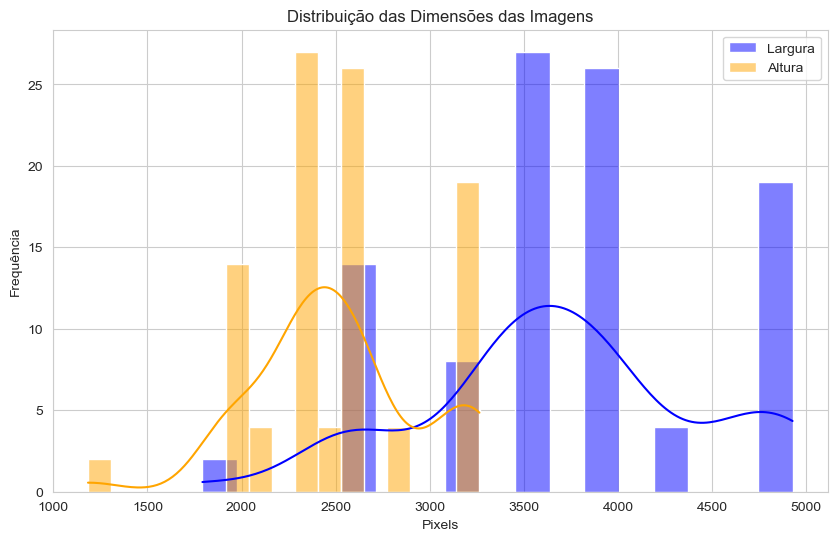

In [5]:
# Conversão para DataFrame para análise
if dimensoes_imagens:
    dimensoes_df = pd.DataFrame(dimensoes_imagens, columns=["Largura", "Altura"])
    print(dimensoes_df.describe())

    # Visualização da distribuição das dimensões
    plt.figure(figsize=(10, 6))
    sns.histplot(dimensoes_df["Largura"], kde=True, color="blue", label="Largura")
    sns.histplot(dimensoes_df["Altura"], kde=True, color="orange", label="Altura")
    plt.title("Distribuição das Dimensões das Imagens")
    plt.xlabel("Pixels")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()

As dimensões das imagens analisadas mostram uma variação significativa de largura e altura, indicando que as imagens podem não estar normalizadas. Imagens com tamanhos inconsistentes podem afetar o desempenho de modelos de aprendizado de máquina, especialmente redes neurais convolucionais (CNNs), que geralmente requerem tamanhos fixos para entrada.

In [6]:
# Verificação da qualidade das imagens (presença de artefatos ou imagens corrompidas)
imagens_corrompidas = []
for file_name in train_files:
    image_path = os.path.join(train_folder_path, file_name)
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verificar se a imagem está corrompida
    except (IOError, SyntaxError):
        imagens_corrompidas.append(file_name)

print(f"Total de imagens corrompidas identificadas: {len(imagens_corrompidas)}")
if imagens_corrompidas:
    print("Exemplo de imagens corrompidas:", imagens_corrompidas[:5])


Total de imagens corrompidas identificadas: 0


In [7]:
# Cálculo do brilho médio das imagens
brilho_imagens = []
contraste_imagens = []
for file_name in train_files[:100]:  # Limitar a análise às primeiras 100 imagens para otimizar tempo
    image_path = os.path.join(train_folder_path, file_name)
    try:
        with Image.open(image_path) as img:
            img_gray = img.convert("L")  # Converter para escala de cinza
            stat = ImageStat.Stat(img_gray)
            brilho = stat.mean[0]
            contraste = stat.stddev[0]
            brilho_imagens.append(brilho)
            contraste_imagens.append(contraste)
    except Exception as e:
        print(f"Erro ao calcular brilho/contraste para {file_name}: {e}")

C:\Users\ainho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ainho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


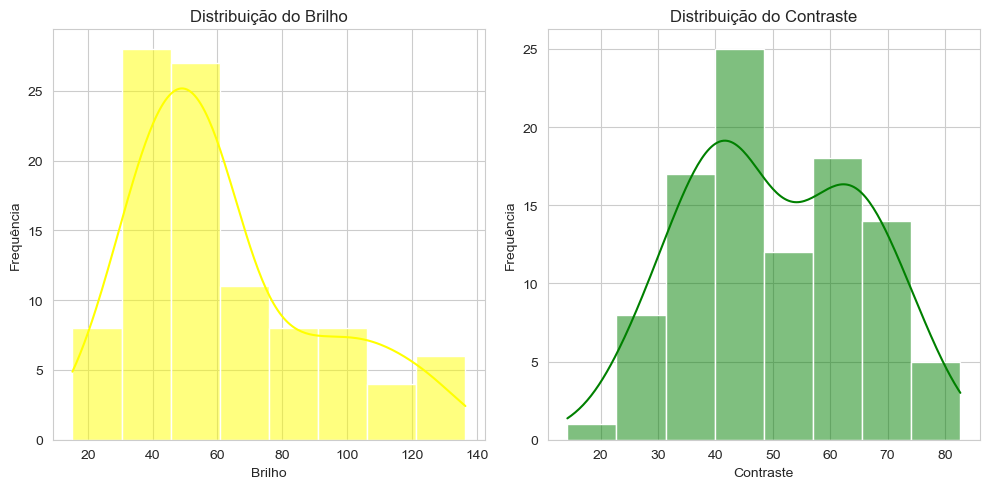

In [8]:
if brilho_imagens and contraste_imagens:
    # Visualização de brilho e contraste
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(brilho_imagens, kde=True, color="yellow")
    plt.title("Distribuição do Brilho")
    plt.xlabel("Brilho")
    plt.ylabel("Frequência")

    plt.subplot(1, 2, 2)
    sns.histplot(contraste_imagens, kde=True, color="green")
    plt.title("Distribuição do Contraste")
    plt.xlabel("Contraste")
    plt.ylabel("Frequência")

    plt.tight_layout()
    plt.show()


A distribuição de brilho mostrou uma amplitude moderada, o que pode indicar diferenças significativas na iluminação das imagens.
O contraste apresentou variações, sugerindo que algumas imagens podem ter detalhes mais difíceis de distinguir, o que pode impactar a detecção de características relevantes.

Mostramos 5 imagens do conjunto de dados para ter uma ideia das imagens com que estamos a trabalhar.

In [9]:
# Visualización de algunas imágenes del dataset
def mostrar_imagenes_ejemplo(image_folder, image_list, num_images=5):
    sample_images = np.random.choice(image_list, num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        image_path = os.path.join(image_folder, sample_images[i])
        try:
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(sample_images[i])
        except FileNotFoundError:
            ax.set_title("Imagen no encontrada")
            ax.axis('off')

mostrar_imagenes_ejemplo(train_folder_path, train_files)

Error in callback <function flush_figures at 0x000001DC0B34D4E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Estado da arte(esta revisão deve ter entre 3 a 4 artigos relacionados)

A retinopatia diabética é uma das principais causas de cegueira no mundo. A análise automática de imagens de retina usando técnicas de aprendizado profundo ganhou muita atenção nos últimos anos. Abaixo estão alguns artigos relevantes:

1. **"Deep Learning Based Early Detection and Grading of Diabetic Retinopathy Using Retinal Fundus Images"**
Este artigo aborda a deteção precoce da retinopatia diabética e a sua classificação utilizando imagens do fundo do olho. Utiliza um modelo de rede neural profunda com técnicas avançadas de aumento de dados para superar o desequilíbrio nos dados de treino. https://arxiv.org/abs/1812.10595


2. **"Diabetic Retinopathy Detection via Deep Convolutional Networks for Discriminative Localization and Visual Explanation"**
   Explora a utilização de redes convolucionais profundas e o mapeamento da ativação por regressão para localizar e classificar regiões discriminatórias em imagens da retina. A abordagem melhora a interpretabilidade do modelo e o desempenho em conjuntos de dados desequilibrados.
https://arxiv.org/abs/1703.10757



3. **"Transfer Learning in Medical Imaging"**
   Este documento analisa a forma como as redes pré-treinadas, como as baseadas no ImageNet, podem ser aplicadas à deteção de patologias em imagens médicas. Os resultados mostram um impacto positivo na precisão e no tempo de formação quando se utiliza a aprendizagem por transferência. https://www.nature.com/articles/s41598-020-78533-6

4. **"Detection and Classification of Diabetic Retinopathy using Deep Learning Algorithms for Segmentation to Facilitate Referral Recommendation for Test and Treatment Prediction"**
   Este artigo discute o uso de redes neurais convolucionais (CNNs) e a aprendizagem por transferência para detetar automaticamente a retinopatia diabética usando uma única fotografia de fundo de olho. Utiliza a arquitetura U-Net para segmentar estruturas retinianas, tais como vasos sanguíneos, exsudados e hemorragias, obtendo uma elevada precisão no concurso APTOS 2019 Blindness Detection (kappa ponderado de 0,92546). Esta abordagem permite uma deteção eficiente e contribui significativamente para a melhoria dos diagnósticos médicos por imagem. https://arxiv.org/abs/2308.00525 e https://arxiv.org/abs/2401.02759

## 2ª parte do Projeto


### METODOLOGIAA seguir, apresento as principais etapas que segui para realizar o projeto, representadas num fluxograma. Nas subsecções, explicarei em pormenor cada uma destas etapas.



#### 1. Dados


Em primeiro lugar, carrego os rótulos de treino a partir do ficheiro trainLabels.csv, que contém a informação sobre o grau de retinopatia diabética (RD) para cada imagem. Este ficheiro é carregado numa DataFrame do pandas, o que me permite manipular e analisar facilmente os dados. Em seguida, imprimo o número total de imagens presentes no conjunto de dados para ter uma ideia da sua dimensão. Além disso, verifico quantas imagens correspondem a cada categoria de DR, o que me permite conhecer a distribuição das classes e perceber se existe algum desequilíbrio no conjunto de dados.

In [10]:
# Cargar etiquetas de entrenamiento
train_labels = pd.read_csv('C:/Users/ainho/Documents/UTAD/DeepLearning/Proyecto Final/trainLabels.csv')
print(f"Número total de imágenes: {len(train_labels)}")
print(train_labels['level'].value_counts())


Número total de imágenes: 35126
level
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64


Quando tenho os dados, gero um gráfico de barras para visualizar a distribuição das classes de retinopatia diabética (RD) no conjunto de treino. Isto ajuda-me a ver claramente quantas imagens existem em cada classe e a identificar possíveis problemas de desequilíbrio, como o facto de uma classe ter significativamente mais imagens do que outras. 

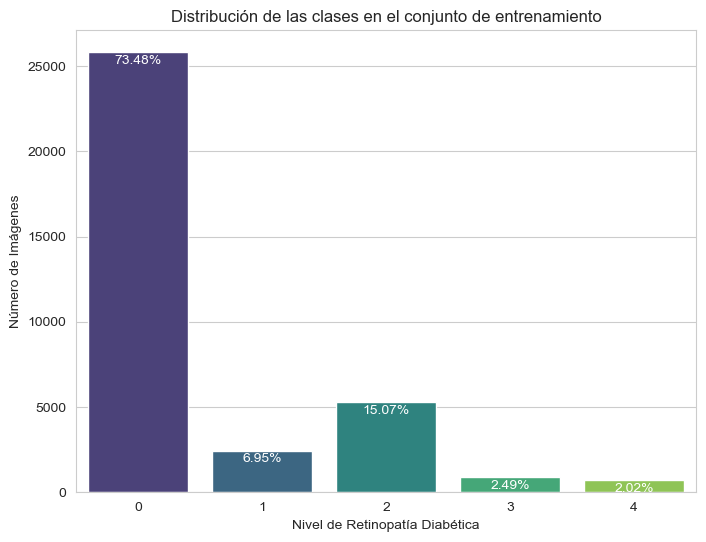

In [11]:
# Visualización de la distribución de clases
plt.figure(figsize=(8,6))
sns.countplot(data=train_labels, x='level', palette='viridis')

# Mostrar porcentajes sobre el gráfico, colocados más abajo
total = len(train_labels)
for p in plt.gca().patches:
    height = p.get_height()
    # Calcular porcentaje
    percentage = height / total * 100
    # Colocar el porcentaje un poco más abajo (ajustando el valor de 'y')
    plt.gca().annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height - 500), 
                       ha='center', va='center', fontsize=10, color='white')

plt.title('Distribución de las clases en el conjunto de entrenamiento')
plt.xlabel('Nivel de Retinopatía Diabética')
plt.ylabel('Número de Imágenes')
plt.show()

Na análise da distribuição das classes, observei um desequilíbrio significativo. A classe 0 (sem retinopatia diabética) representa aproximadamente 73,6% das imagens, enquanto as classes mais graves, como a classe 4 (RD proliferativa), têm apenas 708 imagens, o que equivale a 2% do total. Este desequilíbrio pode fazer com que o modelo seja tendencioso para a classe maioritária, dificultando a deteção de classes sub-representadas, especialmente as mais graves.

Este desequilíbrio pode levar a que o modelo preveja predominantemente a classe 0, afectando a deteção das classes 1, 2, 3 e 4. Para resolver este problema, é essencial aplicar técnicas como o reequilíbrio das classes, a ponderação das classes ou o aumento dos dados, bem como utilizar métricas de avaliação mais adequadas, como o AUC-ROC ou a pontuação F1, para medir de forma mais eficaz o desempenho do modelo nas classes minoritárias.

#### 2. Preprocesamiento


Quanto ao pré-processamento de imagens, implementei uma função que efectua as seguintes operações:

##### 1. Carregamento e conversão de imagens: 
Utilizo o OpenCV para ler as imagens e convertê-las de BGR (formato padrão do OpenCV) para RGB (formato padrão para trabalhar com redes neurais).
##### 2. Redimensionamento: 
As imagens são redimensionadas para um tamanho uniforme de (224, 224) pixéis para facilitar o processamento pela rede neuronal.
##### 3. Normalização: 
Normalizo os valores dos píxeis dividindo-os por 255, o que faz com que os valores passem do intervalo [0, 255] para [0, 1]. Esta normalização é essencial para melhorar a convergência do modelo durante o treino.

In [12]:
# Preprocesamiento de imágenes
def preprocesar_imagen(image_path, target_size=(224, 224)):
    """
    Carga y preprocesa una imagen:
    - Redimensiona a target_size.
    - Normaliza los valores de los píxeles entre 0 y 1.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0 #Normaliza los valores de los píxeles dividiendo entre 255, lo que escala los valores de los píxeles del rango [0, 255] a [0, 1]
    return image


Para carregar todas as imagens de treino e as suas etiquetas correspondentes, utilizei uma função que lê os ficheiros de imagem, processa-os e associa cada imagem à sua etiqueta no conjunto de dados. Isto é feito da seguinte forma:

In [23]:
# Cargar y preprocesar todas las imágenes de entrenamiento y sus etiquetas
def cargar_datos_y_etiquetas(folder_path, file_list, labels_df, target_size=(224, 224)):
    images = []
    labels = []
    for file_name in file_list:
        image_path = os.path.join(folder_path, file_name)
        try:
            image = preprocesar_imagen(image_path, target_size)
            images.append(image)
            # Obtener etiqueta a partir del DataFrame labels_df
            label = labels_df.loc[labels_df['image'] == file_name, 'level'].values[0]
            labels.append(label)
        except Exception as e:
            print(f"Error al procesar {file_name}: {e}")
    return np.array(images), np.array(labels)

train_labels = pd.read_csv("C:/Users/ainho/Documents/UTAD/DeepLearning/Proyecto Final/trainLabels.csv")
train_labels['image'] = train_labels['image'] + ".jpeg"  

# Cargar datos de entrenamiento
X_train, y_train = cargar_datos_y_etiquetas(train_folder_path, train_files, train_labels)


Neste código, cada imagem e sua etiqueta correspondente são carregadas de um DataFrame de etiquetas (trainLabels.csv). Para garantir que os nomes dos ficheiros correspondem aos registos das etiquetas, acrescento a extensão .jpeg ao nome da imagem no DataFrame.

Por fim, converto os rótulos em um formato categórico usando a função to_categorical do Keras, que é essencial para redes neurais, pois os rótulos devem estar em um formato binário para cada classe.

In [24]:
y_train_categorical = to_categorical(y_train, num_classes=5)


Este pré-processamento garante que as imagens estão prontas para serem introduzidas no modelo de rede neural.

No final deste processo, o tamanho das matrizes de imagens e etiquetas resultantes é verificado para confirmar que o processo foi concluído corretamente.

In [25]:
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de y_train: {y_train_categorical.shape}")


Tamaño de X_train: (1427, 224, 224, 3)
Tamaño de y_train: (1427, 5)


Na fase de pré-processamento dos dados, um dos principais problemas com que me deparei foi o desequilíbrio das classes no conjunto de treino. Para enfrentar este desafio e melhorar o desempenho do modelo, especialmente nas classes sub-representadas, decidi aplicar várias técnicas.

#####  2.1 *Sobreamostragem das classes minoritárias*
Em primeiro lugar, concentrei-me em reduzir o desequilíbrio entre as classes, utilizando técnicas como a sobreamostragem das classes minoritárias, que são as classes 3 (Severa) e 4 (DR Proliferativa). Em vez de remover exemplos das classes maioritárias (o que poderia levar à perda de informação valiosa), decidi utilizar técnicas de geração de dados sintéticos, como o SMOTE, para equilibrar o conjunto de dados. Isto permitiu a criação de novos exemplos para as classes sub-representadas, aumentando assim a quantidade de dados disponíveis para treinar o modelo sem perder informação crucial das classes maioritárias.

In [28]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplana cada imagen en un vector 1D

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

Neste caso, o parâmetro sampling_strategy='auto' diz ao SMOTE para gerar exemplos sintéticos suficientes para que todas as classes tenham o mesmo número de instâncias.

Posteriormente, como as imagens foram achatadas em vectores, decidi redimensioná-las para um tamanho mais adequado ao modelo da rede neural, o que me permitiu trabalhar com imagens maiores
:

In [29]:
X_resampled = X_resampled_flat.reshape(-1, 224, 224, 3)
X_resampled = np.array([cv2.resize(img, (256, 256)) for img in X_resampled])


In [30]:
from collections import Counter
class_distribution = Counter(y_resampled)
print(class_distribution)


(5085, 224, 224, 3)
Counter({0: 1017, 3: 1017, 2: 1017, 1: 1017, 4: 1017})


Isto mostra que agora todas as classes (0, 1, 2, 3, 4) têm o mesmo número de instâncias (1017), o que resolveu o desequilíbrio no conjunto de dados.

##### *2.2. División del conjunto de datos:*
Antes de entrenar el modelo, es fundamental dividir los datos en tres conjuntos: entrenamiento, validación y prueba. Esto permite entrenar el modelo con un subconjunto de los datos, ajustar hiperparámetros con otro subconjunto, y finalmente evaluar el modelo en datos no vistos (conjunto de prueba).

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

#HE CAMBIAAADO EEEEESSTOOOOOOO!!!!!!! y por eso da error

In [32]:
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)

print(f"Tamaño de X_train: {X_val.shape}")
print(f"Tamaño de y_train: {y_val.shape}")


Tamaño de X_train: (1272, 224, 224, 3)
Tamaño de y_train: (1272, 5)


#### 3. Entrenamiento del Modelo

Para a fase de treino do modelo, decidi utilizar uma rede neural convolucional (CNN) para tirar partido das capacidades destas redes no processamento de imagens. A estrutura do modelo que criei é a seguinte:

1. Camada **Conv2D (32 filtros)**: A rede começa com uma camada convolucional que utiliza 32 filtros de tamanho (3, 3) e a função de ativação **ReLU** (Rectified Linear Unit). Esta camada detecta padrões básicos, como arestas ou texturas.

2. Camada **MaxPooling2D**: Após a convolução, utilizo uma camada **max pooling** com um tamanho de pool de (2, 2), que reduz as dimensões das imagens e extrai as caraterísticas mais importantes.

3. Camada **Conv2D (64 filtros)**: Na camada convolucional seguinte, aumento o número de filtros para 64 para capturar caraterísticas de imagem mais complexas.

4. **Camada MaxPooling2D**: Mais uma vez, aplico uma camada max pooling para reduzir a dimensionalidade.

5. **Camada convolucional2D (128 filtros)**: São adicionados mais filtros (128) numa nova camada convolucional para captar caraterísticas ainda mais detalhadas.

6. **Camada MaxPooling2D**: Outra camada max pooling para reduzir ainda mais a dimensionalidade.

7. Camada **Flatten**: Para preparar as caraterísticas extraídas pelas camadas convolucionais, aplanei a saída para um vetor 1D. Isto é necessário para que as camadas densas seguintes possam processar os dados.

8. **Camada densa (128 neurónios)**: Esta camada densa, com 128 neurónios, é utilizada para aprender representações de alto nível das caraterísticas previamente extraídas.

9. Camada **Dropout (0,5)**: Para evitar o sobreajuste, utilizei uma camada **dropout** com uma taxa de 0,5, o que significa que 50% dos neurónios são desactivados aleatoriamente durante o treino.

10. **Camada de saída (1 neurónio)**: Finalmente, a camada de saída tem 1 neurónio com a função de ativação **softnax**, uma vez que estamos a realizar uma classificação multiclase (nivel de retinopatia diabética).

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Crear el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 neuronas para clasificación multiclase
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Uma vez que o modelo foi criado e compilado, passei a treiná-lo com os dados de treinamento pré-processados. Para tal, utilizei o método **`fit`** do Keras, que ajusta o modelo aos dados de treino num determinado número de **epochs**.

Para treinar o modelo, utilizei as seguintes definições:

- **`X_train` e `y_train`**: Estes são os dados de entrada e as etiquetas de treino correspondentes.
- **`dados_validação=(X_val, y_val)`**: Especifico os dados de validação para monitorizar o desempenho do modelo durante o treino e evitar o sobreajuste.
- **`epochs=20`**: O número de épocas a utilizar para treinar o modelo. Escolhi 20 épocas como ponto de partida, uma vez que este é um valor razoável para observar a evolução do modelo sem o sobretreinar.
- **`batch_size=32`**: O tamanho do lote determina quantas amostras de dados são processadas antes de atualizar os pesos do modelo. Um valor de 32 é normalmente utilizado.
- **`verbose=1`**: Isto assegura que o progresso do treino é apresentado em pormenor, com uma barra de progresso para cada época.

In [36]:
#entrena el modelo
history = model.fit(
    X_train, y_train,  # Datos de entrenamiento
    validation_data=(X_val, y_val),  # Datos de validación
    epochs=20,  # Número de épocas
    batch_size=32,  # Tamaño del batch
    verbose=1  # Mostrar progreso
)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.2639 - loss: 1.5975 - val_accuracy: 0.3624 - val_loss: 1.5042
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3591 - loss: 1.4855 - val_accuracy: 0.4827 - val_loss: 1.3602
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4514 - loss: 1.3491 - val_accuracy: 0.4725 - val_loss: 1.2389
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.5214 - loss: 1.2293 - val_accuracy: 0.6187 - val_loss: 1.0461
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5817 - loss: 1.0966 - val_accuracy: 0.6454 - val_loss: 0.9315
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6287 - loss: 0.9771 - val_accuracy: 0.7256 - val_loss: 0.8458
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6723 - loss: 0.8690 - val_accuracy: 0.6659 - val_loss: 0.8654
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6824 - loss: 0.8462 - val_accu

Uma vez que o modelo foi treinado com sucesso, decidi salvá-lo para futuras previsões ou avaliações sem a necessidade de treiná-lo novamente. Utilizei a função Keras save() para guardar o modelo num formato de ficheiro .h5, que contém a arquitetura do modelo e os pesos aprendidos durante o treino.

In [37]:
model.save("modelo_retinopatia.h5")

#### 4. Uso de Grad-CAM para Explicación de Predicciones


Para compreender como o modelo toma decisões e quais as partes da imagem que mais influenciam a previsão, utilizei a técnica **Grad-CAM** (Gradient-weighted Class Activation Mapping). Esta técnica gera um mapa de calor que realça as áreas da imagem que mais contribuem para a previsão, o que é especialmente útil para tarefas de diagnóstico médico, como a classificação da retinopatia diabética.

##### 4.1 Implementação do Grad-CAM

A implementação do Grad-CAM está dividida em várias etapas:

1. **Obtenção das activações da última camada convolucional:** Para gerar o mapa de calor, começa-se por obter as activações da última camada convolucional da rede.
   
2. **Calcular os gradientes:** Em seguida, calculam-se os gradientes da previsão em relação às activações da última camada convolucional.

3. **Gerar o mapa de calor:** A partir destes gradientes, o mapa de ativação ponderada é calculado e visualizado como um mapa de calor.

4. **Sobrepor o mapa de calor à imagem original:** Finalmente, o mapa de calor é sobreposto à imagem original para visualizar as áreas que mais influenciaram a previsão do modelo.

In [22]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Función para obtener el Grad-CAM
def get_grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Predicción de la clase más probable
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Normalizar
    heatmap = heatmap / np.max(heatmap)  # Escalar a [0, 1]
    return heatmap

# Función para mostrar solo el heatmap
def display_heatmap(heatmap, img_size):
    # Redimensionar el heatmap a las dimensiones de la imagen original
    heatmap = cv2.resize(heatmap, (img_size[1], img_size[0]))  # (alto, ancho)
    heatmap = np.uint8(255 * heatmap)  # Escalar a [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Aplicar el colormap
    plt.imshow(heatmap)  # Mostrar el heatmap
    plt.axis('off')  # Desactivar los ejes
    plt.show()

# Función para mostrar el Grad-CAM sobre la imagen
def display_grad_cam(img, heatmap, alpha=0.4):
    # Redimensionar el heatmap a las dimensiones de la imagen original
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Redimensionar al tamaño de la imagen
    heatmap = np.uint8(255 * heatmap)  # Escalar a [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Aplicar el colormap

    # Superponer el heatmap sobre la imagen
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    plt.imshow(superimposed_img)  # Mostrar la imagen con el Grad-CAM
    plt.axis('off')  # Desactivar los ejes
    plt.show()

# Cargar el modelo preentrenado (puedes usar otro modelo también)
model = tf.keras.applications.VGG16(weights='imagenet')

# Obtener el nombre de la última capa convolucional
last_conv_layer_name = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name  # Guarda el nombre de la última capa Conv2D

# Función para procesar y aplicar Grad-CAM a todas las imágenes de un directorio
def process_images_in_directory(directory_path):
    # Iterar sobre todos los archivos en el directorio
    for filename in os.listdir(directory_path):
        img_path = os.path.join(directory_path, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            print(f"Procesando: {filename}")

            # Cargar y preprocesar la imagen
            img = image.load_img(img_path, target_size=(224, 224))  # Ajustar al tamaño esperado por el modelo
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.vgg16.preprocess_input(img_array)  # Preprocesar para VGG16

            # Obtener el mapa de activación Grad-CAM
            heatmap = get_grad_cam(model, img_array, last_conv_layer_name)

            # Convertir la imagen original a RGB
            original_img = cv2.imread(img_path)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            # Mostrar el Grad-CAM sobre la imagen
            display_grad_cam(original_img, heatmap)

            # Mostrar solo el gráfico de calor
            display_heatmap(heatmap, img.size)

directory_path = 'train/'  
process_images_in_directory(directory_path)


#### 5. Uso de LIME para Explicación de Predicciones
Nesta secção, utilizei o LIME (Local Interpretable Model-agnostic Explanations) para gerar explicações interpretáveis das previsões feitas pelo modelo. O LIME permite-nos compreender como um modelo toma decisões, concentrando-nos nas partes relevantes de uma imagem. Combinei esta técnica com a Grad-CAM, utilizada anteriormente, para obter explicações mais pormenorizadas sobre as áreas influentes na classificação.

A função get_grad_cam é responsável pela geração do mapa de ativação Grad-CAM para cada imagem. Isto permite visualizar as regiões da imagem que são mais relevantes para a previsão do modelo. O código calcula os gradientes da previsão em relação à saída da última camada convolucional, que fornece o mapa de calor utilizado para realçar as áreas mais activas da imagem.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Esta função é responsável pela apresentação do Grad-CAM sobreposto à imagem original. Primeiro, converte o mapa de calor gerado numa imagem visualizável e, em seguida, sobrepõe-no à imagem original.

In [24]:
def display_grad_cam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = plt.cm.jet(heatmap)[:, :, :3]
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    superimposed_img = heatmap * alpha + img / 255.0
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()



De seguida, implementei o LIME utilizando a classe LimeImageExplainer da biblioteca lime. Esta classe permite explicar as previsões de um modelo localmente, perturbando a imagem e observando como as previsões variam.

In [25]:
def explain_with_lime(model, img, preprocess_function):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img.astype('double'), classifier_fn=lambda x: model.predict(preprocess_function(x)), top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()

Neste código, a função explain_with_lime recebe uma imagem de entrada e gera uma explicação da classificação do modelo. É efectuada uma perturbação da imagem e é apresentada uma visualização com margens marcadas que indicam as regiões relevantes que contribuem para a previsão.

**Exemplo de utilização com uma imagem de validação**.

Finalmente, o LIME é aplicado a uma imagem do conjunto de validação. A imagem é normalizada antes de ser passada para o modelo e, em seguida, o resultado é visualizado utilizando a função explain_with_lime.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

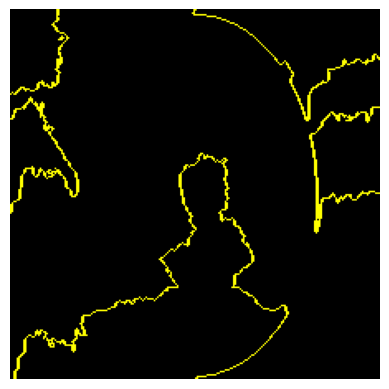

In [26]:
example_img = X_val[0]
explain_with_lime(model, example_img, preprocess_function=lambda x: x / 255.0)


Utilizando o código acima, obtém-se uma visualização na qual são destacadas as áreas da imagem que mais contribuem para a previsão da retinopatia diabética. Esta técnica ajuda a interpretar as decisões do modelo, mostrando as regiões mais relevantes da imagem, fornecendo explicações mais compreensíveis sobre a forma como o modelo efectua as suas classificações.

### RESULTADOS PRELIMINARES

In [38]:
import cv2
import os
import numpy as np

# Tamaño al que se redimensionarán las imágenes
image_size = (224, 224)

def load_test_images(folder_path):
    """
    Carga imágenes de la carpeta de prueba y las prepara para el modelo.
    
    Args:
        folder_path (str): Ruta de la carpeta que contiene las imágenes de prueba.
    
    Returns:
        np.ndarray: Arreglo de imágenes procesadas.
    """
    images = []
    image_names = []
    
    # Iterar sobre las imágenes en la carpeta
    for file_name in os.listdir(folder_path):
        if file_name.endswith(('.jpeg')):  # Asegurarse de que son imágenes
            image_path = os.path.join(folder_path, file_name)
            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, image_size)
            images.append(img_resized)
            image_names.append(file_name.split('.')[0])  # Almacenar nombres sin extensión
    
    return np.array(images), image_names

# Cargar imágenes desde la carpeta "test"
X_test, test_image_names = load_test_images(test_folder_path)

# Normalización de las imágenes
X_test = X_test / 255.0



In [39]:
# Realizar predicciones sobre las imágenes de prueba
def predict_test_images(model, test_images, image_names):
    """
    Realiza predicciones sobre el conjunto de prueba.

    Args:
        model: Modelo entrenado.
        test_images (np.ndarray): Imágenes de prueba normalizadas.
        image_names (list): Nombres de las imágenes en el conjunto de prueba.

    Returns:
        pd.DataFrame: DataFrame con los nombres de las imágenes y las predicciones.
    """
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)  # Clase predicha más probable

    # Crear un DataFrame con los resultados
    results = pd.DataFrame({
        "image": image_names,
        "predicted_level": predicted_labels
    })
    return results

# Generar predicciones
test_results = predict_test_images(model, X_test, test_image_names)

# Guardar las predicciones en un archivo CSV
output_csv_path = "test_predictions.csv"
test_results.to_csv(output_csv_path, index=False)
print(f"Predicciones guardadas en '{output_csv_path}'.")


92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step
Predicciones guardadas en 'test_predictions.csv'.


In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

y_val = np.argmax(y_val, axis=1)  
y_train = np.argmax(y_train, axis=1) 
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.8881 - loss: 0.3221
Loss: 0.34397798776626587
Accuracy: 0.8710691928863525


In [45]:
from sklearn.metrics import classification_report

# Predicciones preliminares
predictions = model.predict(X_val)

# Reporte de clasificación
predicted_classes = np.argmax(predictions, axis=1)
print(classification_report(y_val, predicted_classes))


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step
              precision    recall  f1-score   support

           0       0.85      0.58      0.69       274
           1       0.86      0.96      0.91       248
           2       0.72      0.83      0.77       233
           3       0.96      1.00      0.98       263
           4       0.95      1.00      0.98       254

    accuracy                           0.87      1272
   macro avg       0.87      0.87      0.87      1272
weighted avg       0.87      0.87      0.86      1272



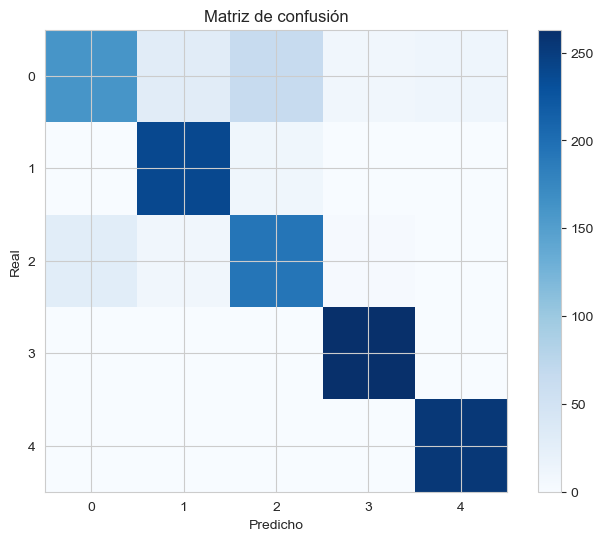

In [46]:
from sklearn.metrics import confusion_matrix
# Matriz de confusión
conf_matrix = confusion_matrix(y_val, predicted_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.colorbar()
plt.show()


In [ ]:
import shap
# SHAP: Análisis explicativo
explainer = shap.GradientExplainer(model, X_val)
shap_values = explainer.shap_values(X_val[:5])

# Visualizar explicaciones de SHAP
shap.image_plot(shap_values, X_val[:5])